<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 3
Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 10
## <center> Прогнозирование задержек вылетов

Ваша задача – побить как минимум 2 бенчмарка в [соревновании](https://www.kaggle.com/c/flight-delays-spring-2018) на Kaggle Inclass. Подробных инструкций не будет, будет только тезисно описано, как получен второй – с помощью Xgboost. Надеюсь, на данном этапе курса вам достаточно бросить полтора взгляда на данные, чтоб понять, что это тот тип задачи, в которой затащит градиентный бустинг. Скорее всего Xgboost, но тут у нас еще немало категориальных признаков...

<img src='../../img/xgboost_meme.jpg' width=40% />

In [34]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_auc_score
%matplotlib inline


from pylab import rcParams
rcParams['figure.figsize'] = 18, 15

In [110]:
train = pd.read_csv('flight_delays_train.csv')
test = pd.read_csv('flight_delays_test.csv')

In [111]:
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [112]:
test.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,c-7,c-25,c-3,615,YV,MRY,PHX,598
1,c-4,c-17,c-2,739,WN,LAS,HOU,1235
2,c-12,c-2,c-7,651,MQ,GSP,ORD,577
3,c-3,c-25,c-7,1614,WN,BWI,MHT,377
4,c-6,c-6,c-3,1505,UA,ORD,STL,258


Итак, надо по времени вылета самолета, коду авиакомпании-перевозчика, месту вылета и прилета и расстоянию между аэропортами вылета и прилета предсказать задержку вылета более 15 минут. В качестве простейшего бенчмарка возьмем логистическую регрессию и два признака, которые проще всего взять: `DepTime` и `Distance`. У такой модели результат – 0.68202 на LB. 

In [5]:
X_train, y_train = train[['Distance', 'DepTime']].values, train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_test = test[['Distance', 'DepTime']].values

X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=17)

scaler = StandardScaler()
X_train_part = scaler.fit_transform(X_train_part)
X_valid = scaler.transform(X_valid)

In [6]:
logit = LogisticRegression()

logit.fit(X_train_part, y_train_part)
logit_valid_pred = logit.predict_proba(X_valid)[:, 1]

roc_auc_score(y_valid, logit_valid_pred)

0.67956914653526068

In [20]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

logit.fit(X_train_scaled, y_train)
logit_test_pred = logit.predict_proba(X_test_scaled)[:, 1]

pd.Series(logit_test_pred, name='dep_delayed_15min').to_csv('logit_2feat.csv', index_label='id', header=True)

Второй бенчмарк, представленный в рейтинге соревнования, был получен так:
- Признаки `Distance` и  `DepTime` брались без изменений
- Создан признак "маршрут" из исходных `Origin` и `Dest`
- К признакам `Month`, `DayofMonth`, `DayOfWeek`, `UniqueCarrier` и "маршрут" применено OHE-преобразование (`LabelBinarizer`)
- Выделена отложенная выборка
- Обучалась логистическая регрессия и градиентный бустинг (xgboost), гиперпараметры бустинга настраивались на кросс-валидации, сначала те, что отвечают за сложность модели, затем число деревьев фиксировалось равным 500 и настраивался шаг градиентного спуска
- С помощью `cross_val_predict` делались прогнозы обеих моделей на кросс-валидации (именно предсказанные вероятности), настраивалась линейная смесь ответов логистической регрессии и градиентного бустинга вида $w_1 * p_{logit} + (1 - w_1) * p_{xgb}$, где $p_{logit}$ – предсказанные логистической регрессией вероятности класса 1, $p_{xgb}$ – аналогично. Вес $w_1$ подбирался вручную. 
- В качестве ответа для тестовой выборки бралась аналогичная комбинация ответов двух моделей, но уже обученных на всей обучающей выборке.

Описанный план ни к чему не обязывает – это просто то, как решение получил автор задания. Возможно, вы не захотите следовать намеченному плану, а добавите, скажем, пару хороших признаков и обучите лес из тысячи деревьев.

Удачи!

In [113]:
y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
full = pd.concat([train.drop('dep_delayed_15min', axis=1), test])
idx_split = train.shape[0]
full.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732
1,c-4,c-20,c-3,1548,US,PIT,MCO,834
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423


In [114]:
full.shape

(200000, 8)

In [13]:
%%time
rows_list = []
for index, row in full.iterrows():
    if (row['Distance'] <= 250):
        row['Distance_scale'] = 'less_250'
    elif ((row['Distance'] > 250) and (row['Distance'] <= 500)):
        row['Distance_scale'] = '250_500'
    elif ((row['Distance'] > 500) and (row['Distance'] <= 750)):
        row['Distance_scale'] = '500_750'
    elif ((row['Distance'] > 750) and (row['Distance'] <= 1000)):
        row['Distance_scale'] = '750_1000'
    elif ((row['Distance'] > 1000) and (row['Distance'] <= 1250)):
        row['Distance_scale'] = '1000_1250'
    elif ((row['Distance'] > 1250) and (row['Distance'] <= 1500)):
        row['Distance_scale'] = '1250_1500'  
    elif ((row['Distance'] > 1500) and (row['Distance'] <= 1750)):
        row['Distance_scale'] = '1500_1750'
    elif ((row['Distance'] > 1750) and (row['Distance'] <= 2000)):
        row['Distance_scale'] = '1750_2000'
    elif ((row['Distance'] > 2000) and (row['Distance'] <= 2250)):
        row['Distance_scale'] = '2000_2250'
    elif ((row['Distance'] > 2250) and (row['Distance'] <= 2500)):
        row['Distance_scale'] = '2250_2500'
    elif ((row['Distance'] > 2500) and (row['Distance'] <= 2750)):
        row['Distance_scale'] = '2500_2750' 
    elif ((row['Distance'] > 2750) and (row['Distance'] <= 3000)):
        row['Distance_scale'] = '2750_3000'         
    else:
        row['Distance_scale'] = 'more_3000'
    rows_list.append(row)
temp_full_df = pd.DataFrame(rows_list)    
temp_full_df.head()
full = temp_full_df

Wall time: 4min 13s


In [50]:
%%time
rows_list = []
for index, row in tqdm(full.iterrows(), total = 200000):
    if (row['DepTime'] <= 600):
        row['DepTime_scale'] = 'less_6:00'
    elif ((row['DepTime'] > 600) and (row['DepTime'] <= 900)):
        row['DepTime_scale'] = '6:00_9:00'
    elif ((row['DepTime'] > 900) and (row['DepTime'] <= 1200)):
        row['DepTime_scale'] = '9:00_12:00'
    elif ((row['DepTime'] > 1200) and (row['DepTime'] <= 1500)):
        row['DepTime_scale'] = '12:00_15:00'
    elif ((row['DepTime'] > 1500) and (row['DepTime'] <= 1800)):
        row['DepTime_scale'] = '15:00_18:00'
    elif ((row['DepTime'] > 1800) and (row['DepTime'] <= 2100)):
        row['DepTime_scale'] = '18:00_21:00'  
    elif ((row['DepTime'] > 2100) and (row['DepTime'] <= 2400)):
        row['DepTime_scale'] = '21:00_24:00'      
    rows_list.append(row)
temp_full_df = pd.DataFrame(rows_list)    
temp_full_df.head()
full = temp_full_df

100%|██████████| 200000/200000 [01:34<00:00, 2120.65it/s]


Wall time: 1min 47s


In [101]:
%%time
rows_list = []
for index, row in tqdm(full.iterrows(), total = 200000):
    if (row['DepTime'] <= 1200):
        row['DepTime_part_of_day'] = 'Before_midday'
    elif (row['DepTime'] > 1200):
        row['DepTime_part_of_day'] = 'After_midday'
    rows_list.append(row)
temp_full_df = pd.DataFrame(rows_list)    
temp_full_df.head()
full = temp_full_df

100%|██████████| 200000/200000 [01:41<00:00, 1965.15it/s]


Wall time: 1min 58s


In [115]:
%%time
rows_list = []
for index, row in tqdm(full.iterrows(), total = 200000):
    if (row['DepTime'] <= 1000):
        row['DepTime_third'] = '0:00_10:00'
    elif ((row['DepTime'] > 1000) and (row['DepTime'] <= 2100)):
        row['DepTime_third'] = '10:00_21:00'
    elif ((row['DepTime'] > 2100) and (row['DepTime'] <= 2400)):
        row['DepTime_third'] = '21:00_24:00'     
    rows_list.append(row)
temp_full_df = pd.DataFrame(rows_list)    
temp_full_df.head()
full = temp_full_df

100%|██████████| 200000/200000 [01:44<00:00, 1906.23it/s]


Wall time: 1min 59s


In [125]:
#Добавляем признак Маршрут
full['Route'] = full['Origin'] + '-' + full['Dest']

In [102]:
%%time
rows_list = []
for index, row in tqdm(train.iterrows(), total = 100000):
    if (row['DepTime'] <= 1000):
        row['DepTime_third'] = '0:00_10:00'
    elif ((row['DepTime'] > 1000) and (row['DepTime'] <= 2100)):
        row['DepTime_third'] = '10:00_21:00'
    elif ((row['DepTime'] > 2100) and (row['DepTime'] <= 2400)):
        row['DepTime_third'] = '21:00_24:00'     
    rows_list.append(row)
temp_full_df = pd.DataFrame(rows_list)    
temp_full_df.head()
train = temp_full_df

100%|██████████| 100000/100000 [00:50<00:00, 1967.30it/s]


Wall time: 57.9 s


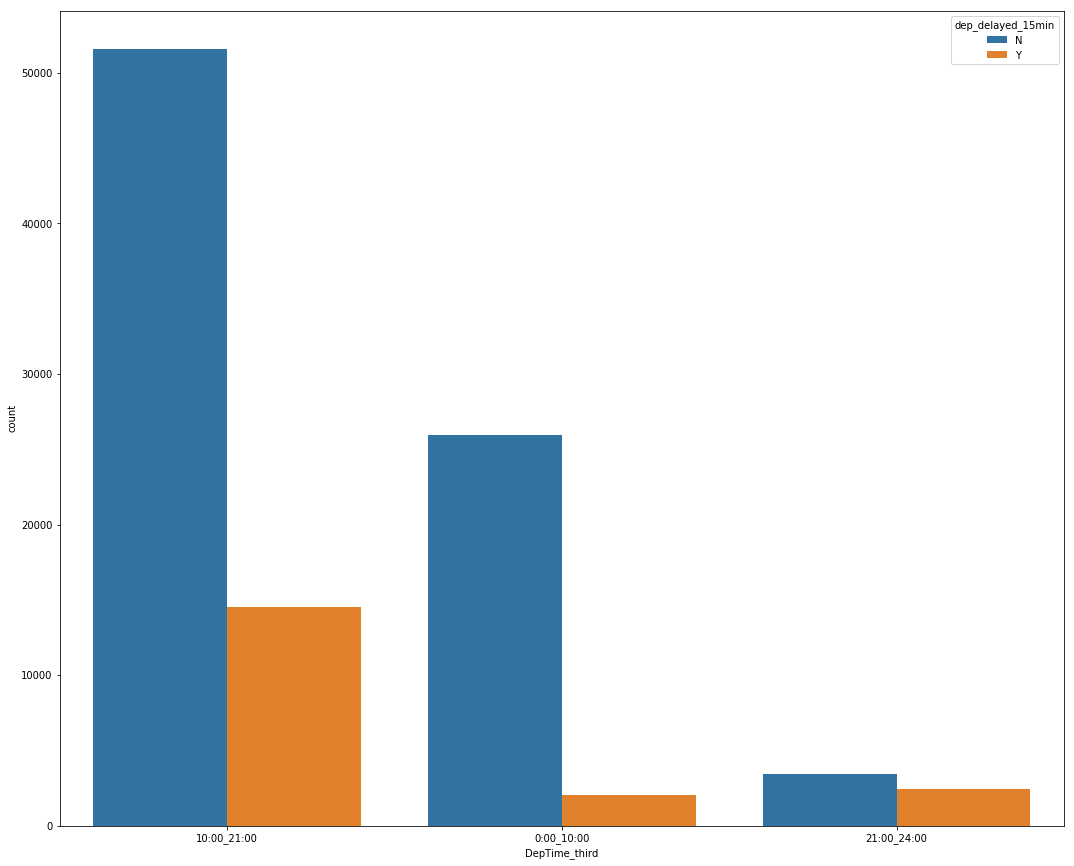

In [103]:
sns.countplot(x='DepTime_third', hue='dep_delayed_15min', data=train);

In [44]:
%%time
rows_list = []
for index, row in tqdm(train.iterrows(), total = 100000):
    if (row['DepTime'] <= 600):
        row['DepTime_scale'] = 'less_6:00'
    elif ((row['DepTime'] > 600) and (row['DepTime'] <= 900)):
        row['DepTime_scale'] = '6:00_9:00'
    elif ((row['DepTime'] > 900) and (row['DepTime'] <= 1200)):
        row['DepTime_scale'] = '9:00_12:00'
    elif ((row['DepTime'] > 1200) and (row['DepTime'] <= 1500)):
        row['DepTime_scale'] = '12:00_15:00'
    elif ((row['DepTime'] > 1500) and (row['DepTime'] <= 1800)):
        row['DepTime_scale'] = '15:00_18:00'
    elif ((row['DepTime'] > 1800) and (row['DepTime'] <= 2100)):
        row['DepTime_scale'] = '18:00_21:00'  
    elif ((row['DepTime'] > 2100) and (row['DepTime'] <= 2400)):
        row['DepTime_scale'] = '21:00_24:00'      
    rows_list.append(row)
temp_full_df = pd.DataFrame(rows_list)    
temp_full_df.head()
train = temp_full_df

100%|██████████| 100000/100000 [00:55<00:00, 1800.52it/s]


Wall time: 1min 3s


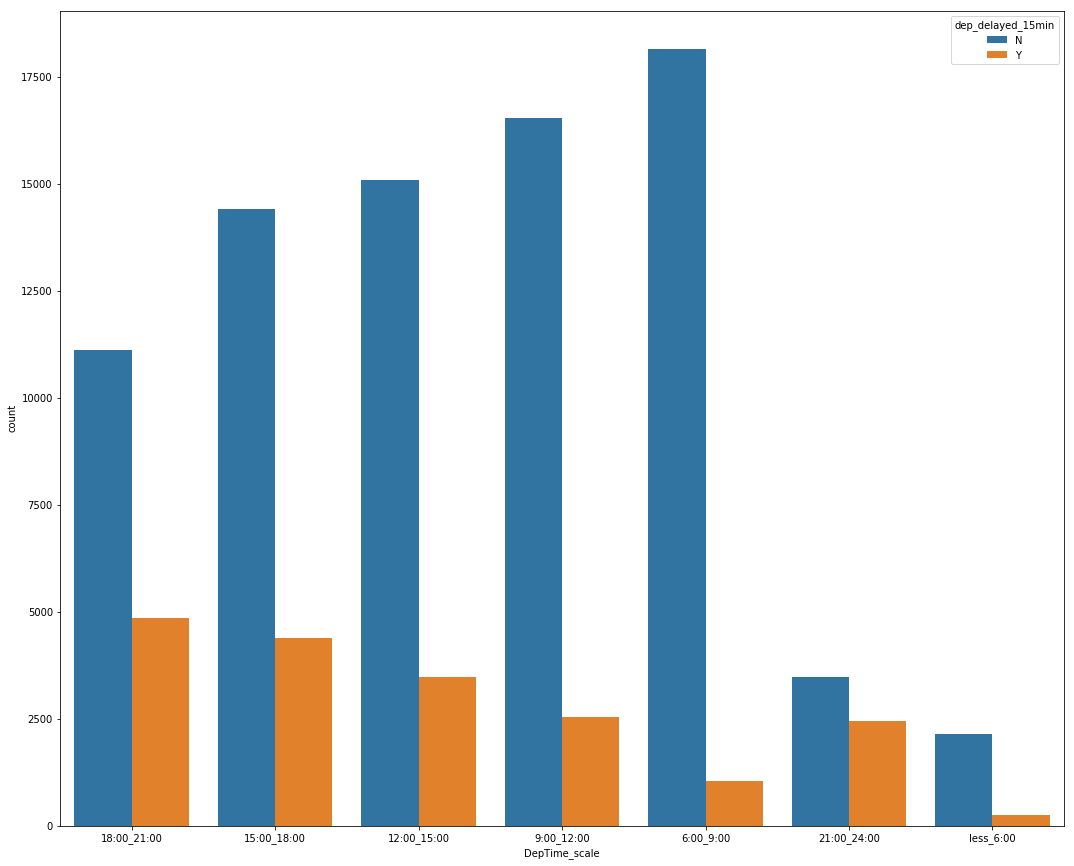

In [46]:
sns.countplot(x='DepTime_scale', hue='dep_delayed_15min', data=train);

In [81]:
%%time
rows_list = []
for index, row in train.iterrows():
    if (row['DepTime'] <= 1200):
        row['DepTime_part_of_day'] = 'Before_midday'
    elif (row['DepTime'] > 1200):
        row['DepTime_part_of_day'] = 'After_midday'
    rows_list.append(row)
temp_full_df = pd.DataFrame(rows_list)    
temp_full_df.head()
train = temp_full_df

Wall time: 54.9 s


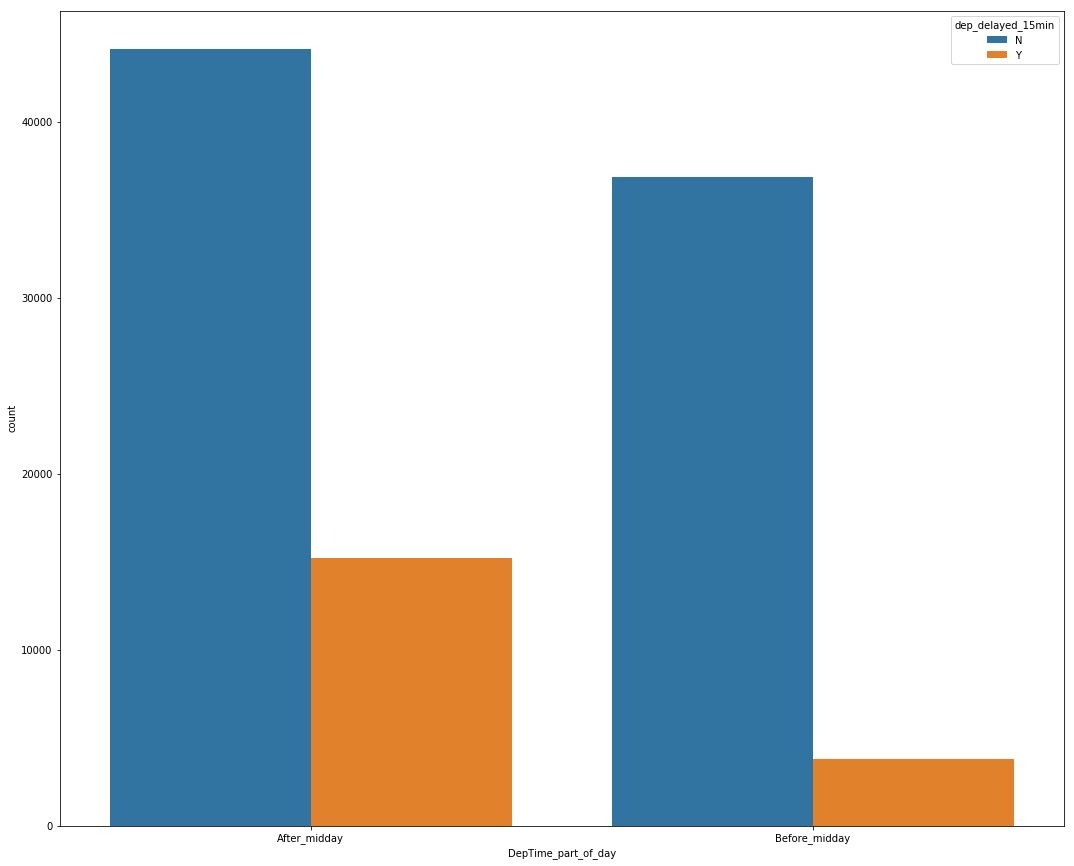

In [82]:
sns.countplot(x='DepTime_part_of_day', hue='dep_delayed_15min', data=train);

In [117]:
%%time

#full = pd.get_dummies(full, drop_first = True, columns=['DepTime_part_of_day'], prefix='DepTime_part_of_day')
#full = pd.get_dummies(full, drop_first = True, columns=['DepTime_scale'], prefix='DepTime_scale')
#full = pd.get_dummies(full, drop_first = True, columns=['Distance_scale'], prefix='Distance_scale')
full = pd.get_dummies(full, columns=['DepTime_third'], prefix='DepTime_third')

Wall time: 58 ms


In [126]:
%%time

full = pd.get_dummies(full, drop_first = True, columns=['Month'], prefix='Month')
full = pd.get_dummies(full, drop_first = True, columns=['DayofMonth'], prefix='DayofMonth')
full = pd.get_dummies(full, drop_first = True, columns=['DayOfWeek'], prefix='DayOfWeek')
full = pd.get_dummies(full, drop_first = True, columns=['UniqueCarrier'], prefix='UniqueCarrier')
full = pd.get_dummies(full, drop_first = True, columns=['Route'], prefix='Route')

Wall time: 12.9 s


In [119]:
full.drop('Dest', axis = 1, inplace=True)
full.drop('Origin', axis = 1, inplace=True)
full.drop('UniqueCarrier', axis = 1, inplace=True)
full.drop('DayOfWeek', axis = 1, inplace=True)
full.drop('DayofMonth', axis = 1, inplace=True)
full.drop('Month', axis = 1, inplace=True)

In [147]:
full.head()

,DepTime,Distance,DepTime_third_0:00_10:00,DepTime_third_10:00_21:00,DepTime_third_21:00_24:00
0,1934,732,0,1,0
1,1548,834,0,1,0
2,1422,416,0,1,0
3,1015,872,0,1,0
4,1828,423,0,1,0


In [34]:
#full_sparsed = sp.sparse.csr_matrix(full.values)

In [121]:
X_test = full.iloc[idx_split:, :]
X_train = full.iloc[:idx_split, :]

In [136]:
X_train.shape, X_test.shape

((100000, 5), (100000, 5))

In [137]:
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=17)

In [148]:
scaler = StandardScaler()
X_train_part = scaler.fit_transform(X_train_part)
X_valid = scaler.transform(X_valid)
X_train_scaled = scaler.fit_transform(X_train)

In [139]:
skf = StratifiedKFold(n_splits=9, shuffle=True)

In [151]:
%%time
rfc = RandomForestClassifier(n_estimators=30, n_jobs=-1, oob_score=True)
results = cross_val_score(rfc, X_train_scaled, y_train, cv=skf, scoring ='roc_auc')
print("CV accuracy score: {:.2f}%".format(results.mean()*100))

CV accuracy score: 66.44%
Wall time: 13.5 s


In [144]:
logit_cv = LogisticRegressionCV(Cs = [600, 700], n_jobs=-1, scoring ='roc_auc', cv=skf)
logit_cv.fit(X_train_scaled, y_train)
logit_cv.scores_

{1: array([[ 0.66587833,  0.66587818],
        [ 0.69023252,  0.69023205],
        [ 0.68867726,  0.68867736],
        [ 0.67265176,  0.6726526 ],
        [ 0.6778357 ,  0.67783549],
        [ 0.69263472,  0.69263472],
        [ 0.69117896,  0.69117896],
        [ 0.67979134,  0.67979092],
        [ 0.68053934,  0.68053944]])}

In [97]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

logit_cv.fit(X_train_scaled, y_train)
logit_test_pred = logit_cv.predict_proba(X_test_scaled)[:, 1]

pd.Series(logit_test_pred, name='dep_delayed_15min').to_csv('logit_2feat.csv', index_label='id', header=True)

In [152]:
%%time
params = {
    'objective': 'binary:logistic',
    'max_depth': 5,
    'learning_rate': 0.05,
    'silent': 0,
    'n_estimators': 50,
    'booster':'gbtree'
}
xgb_model = XGBClassifier(**params).fit(X_train_part, y_train_part)

Wall time: 1.03 s


In [153]:
#logit_valid_pred = logit.predict_proba(X_valid)[:, 1]
preds_prob = xgb_model.predict(X_valid)
roc_auc_score(y_valid, preds_prob)

0.52353236877644371